In [37]:
# Custom round robin

import random
import pandas as pd
from itertools import combinations, chain

import matplotlib.pyplot as plt
import numpy as np

numtrials = 1000


In [38]:
countries = [
    'Argentina', 
    'Brazil', 
    'Colombia', 
    'Uraguay', 
    'Ecuador', 
    'Mexico', 
    'Panama', 
    'Morocco', 
    'Egypt', 
    'Spain', 
    'UK', 
    'Italy', 
    'France', 
    'Germany', 
    'Netherlands', 
    'Japan', 
    'South Korea', 
    "Australia", 
    'Turkey', 
    'New Zealand'
]

pools = {
    1: ['Argentina', 'Brazil', 'Colombia', 'Uraguay', 'Ecuador'],
    2: ['Mexico', 'Panama', 'Morocco', 'Egypt', 'Spain'],
    3: ['UK', 'Italy', 'France', 'Germany', 'Netherlands'],
    4: ['Japan', 'South Korea', "Australia", 'Turkey', 'New Zealand']
}

countriesratings = {
    'Argentina': 2140, 
    'Brazil': 1994, 
    'Colombia': 1953, 
    'Uraguay': 1922, 
    'Ecuador': 1911, 
    'Mexico': 1817, 
    'Panama': 1724, 
    'Morocco': 1807, 
    'Egypt': 1668, 
    'Spain': 2150, 
    'UK': 2012, 
    'Italy': 1914, 
    'France': 2031, 
    'Germany': 1988, 
    'Netherlands': 1967, 
    'Japan': 1875, 
    'South Korea': 1745, 
    "Australia": 1736, 
    'Turkey': 1837, 
    'New Zealand': 1596
}

In [39]:
def winrate(country1, country2):
    return (1/(1 + 10**((countriesratings[country2]-countriesratings[country1])/400)))

In [40]:
def simulate_match(country1, country2):
    
    percent1 = winrate(country1, country2)
    
    if random.random() < percent1:
        result = 'win'
    else:
        result = 'loss'
    
    if result == 'win':
        return country1, 3, country2, 0  # country1 wins, gets 3 points, country2 gets 0
    elif result == 'loss':
        return country1, 0, country2, 3  # country2 wins, gets 3 points, country1 gets 0
    else:
        return country1, 1, country2, 1  # Draw, both get 1 point each

In [41]:
def init_standings(teams):
    return {team: {'wins': 0, 'losses': 0, 'draws': 0, 'points': 0} for team in teams}

In [42]:
def round_robin(teams):
    standings = init_standings(teams)
    for team1, team2 in combinations(teams, 2):
        t1, p1, t2, p2 = simulate_match(team1, team2)
        standings[t1]['points'] += p1
        standings[t2]['points'] += p2
        if p1 == 3:
            standings[t1]['wins'] += 1
            standings[t2]['losses'] += 1
        elif p2 == 3:
            standings[t2]['wins'] += 1
            standings[t1]['losses'] += 1
        else:
            standings[t1]['draws'] += 1
            standings[t2]['draws'] += 1
    return standings


In [43]:

def sort_standings(standings):
    df = pd.DataFrame(standings).T
    df = df.sort_values(by=['points', 'wins'], ascending=False)
    return df

In [44]:

def simulate_knockout(teams):
    seeded = []
    
    for country in teams:
        seeded.append((country, countriesratings[country]))
    
    seeded.sort(key=lambda x: x[1], reverse=True)
    quarter_finalists = [seeded[0][0], seeded[7][0], seeded[3][0], seeded[4][0], seeded[1][0], seeded[6][0], seeded[2][0], seeded[5][0]]
    semi_finalists = []
    bottom4 = []
    thirdfourth = []
    

    # Quarterfinals
    for i in range(0, 8, 2):
        team1, team2 = quarter_finalists[i], quarter_finalists[i+1]
        winner = simulate_match(team1, team2)[0 if random.random() < winrate(team1, team2) else 2]
        semi_finalists.append(winner)
        if winner != team1:
            bottom4.append(team1)
        else:
            bottom4.append(team2)
    
    # Sort bottom4 based on the order they appear in the list seeded
    bottom4.sort(key=lambda x: next(i for i, v in enumerate(seeded) if v[0] == x))

    # Semifinals
    finalists = []
    for i in range(0, 4, 2):
        team1, team2 = semi_finalists[i], semi_finalists[i+1]
        winner = simulate_match(team1, team2)[0 if random.random() < winrate(team1, team2) else 2]
        finalists.append(winner)
        if winner != team1:
            thirdfourth.append(team1)
        else:
            thirdfourth.append(team2)
    thirdfourth.sort(key=lambda x: next(i for i, v in enumerate(seeded) if v[0] == x))
    

    # Final
    final_winner = simulate_match(finalists[0], finalists[1])[0 if random.random() < winrate(team1, team2) else 2]
    if final_winner != finalists[0]:
        second = finalists[0]
    else:
        second = finalists[1]
    
    return {
        bottom4[0]: 5,
        bottom4[1]: 6,
        bottom4[2]: 7,
        bottom4[3]: 8,
        thirdfourth[0]: 3,
        thirdfourth[1]: 4,
        second: 2,
        final_winner: 1
    }


{'Argentina': 2.939, 'Brazil': 6.414, 'Colombia': 8.519, 'Uraguay': 9.989, 'Ecuador': 10.838, 'Mexico': 12.364, 'Panama': 15.903, 'Morocco': 13.483, 'Egypt': 17.555, 'Spain': 2.515, 'UK': 6.039, 'Italy': 10.039, 'France': 5.644, 'Germany': 8.067, 'Netherlands': 9.393, 'Japan': 8.79, 'South Korea': 15.167, 'Australia': 15.443, 'Turkey': 12.082, 'New Zealand': 18.817}


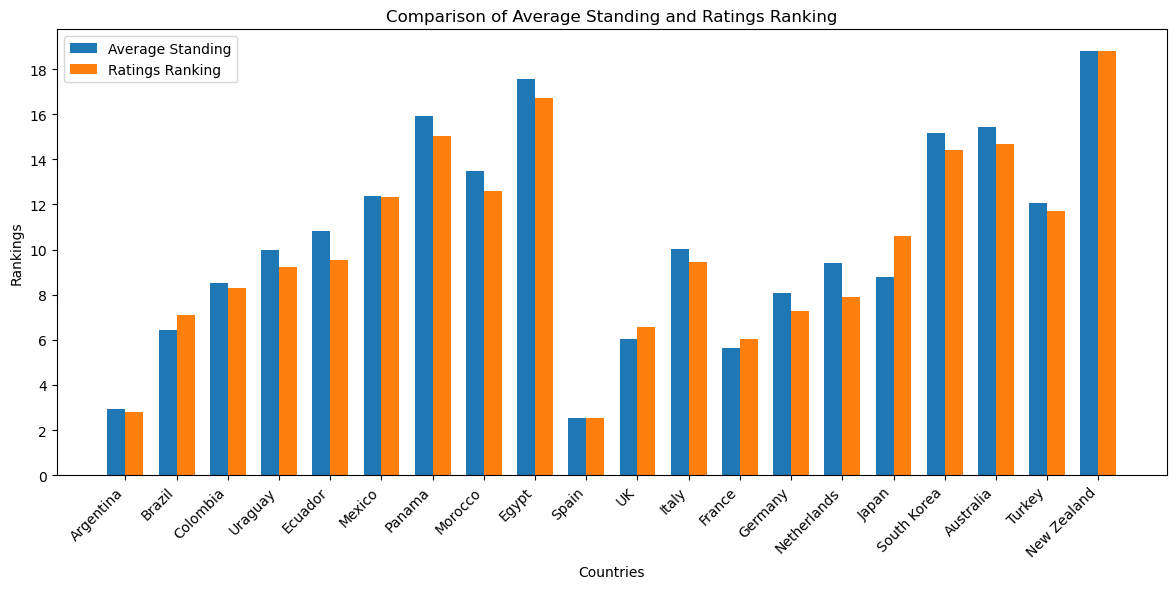

In [45]:

winners = {country: 0 for country in countries}
avgstandings = {country: 0 for country in countries}

for i in range(numtrials):

    pool_results = {}
    direct_to_quarters = []
    qualifier_candidates = []
    bottom12 = []

    # ---------- Phase 1: Group Roundrobin ----------
    for pool_name, teams in pools.items():
        standings = round_robin(teams)
        df = sort_standings(standings)
        pool_results[pool_name] = df
        direct_to_quarters.append(df.index[0])            # Top 1 to quarters
        qualifier_candidates.extend(df.index[1:3]) 
        bottom12.extend(df.index[3:5])

    # ---------- Phase 2: Qualifiers: Next 8 teams run in qualifiers ----------
    qualifier_results = round_robin(qualifier_candidates)
    qualifier_df = sort_standings(qualifier_results)
    qualifier_top4 = list(qualifier_df.index[:4])
    bottom12.extend(qualifier_df.index[4:])

    # ---------- Phase 3: Knockout ----------
    knockout_teams = direct_to_quarters + qualifier_top4
    knockout_results = simulate_knockout(knockout_teams)

    
    # ---------- Phase 4: Placement Round ----------
    placement_results = round_robin(bottom12)
    placement_df = sort_standings(placement_results)
    
    sorted_placement = sorted(placement_results.keys(), key=lambda x: placement_results[x]['points'], reverse=True)
    
    standings = init_standings(countries)
    
    rank = 9
    for country in sorted_placement:
        standings[country] = rank
        rank += 1
    
    sorted_knockout = sorted(knockout_results.items(), key=lambda x: x[1])
    for country, position in sorted_knockout:
        standings[country] = position
    
    for country, position in standings.items():
        if position == 1:
            winners[country] += 1
            
        avgstandings[country] += position

for country, position in avgstandings.items():
    avgstandings[country] = position/numtrials
print(avgstandings)



# ---------------------------- PLOTTING ---------------------------------
# Calculate rankings based on countriesratings
ratings_ranking = {country: rank for rank, country in enumerate(sorted(countriesratings, key=countriesratings.get, reverse=True), start=1)}

# Prepare data for the bar graph
avg_standings_values = [avgstandings[country] for country in countries]

# Perform max-min normalization for ratings
min_avg_standing = min(avg_standings_values)
max_avg_standing = max(avg_standings_values)

normalized_ratings = {
    country: max_avg_standing - ((max_avg_standing - min_avg_standing) * (countriesratings[country] - min(countriesratings.values())) / 
                                 (max(countriesratings.values()) - min(countriesratings.values())))
    for country in countries
}

ratings_ranking_values = [normalized_ratings[country] for country in countries]

x = np.arange(len(countries))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, avg_standings_values, width, label='Average Standing')
rects2 = ax.bar(x + width/2, ratings_ranking_values, width, label='Ratings Ranking')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Countries')
ax.set_ylabel('Rankings')
ax.set_title('Comparison of Average Standing and Ratings Ranking')
ax.set_xticks(x)
ax.set_xticklabels(countries, rotation=45, ha='right')
ax.legend()
fig.tight_layout()

ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.show()


